*******************************************************************************************************
# Data Sceince Project
## **Battle of the Neighborhoods: Final**
### Coffee shop in NYC
_Kinfe Woldeyohannes_
*******************************************************************************************************

**Load Libraries**

In [1]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge geopy --yes 

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


**Foursquare API credentials**

In [75]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token

VERSION = '20210106' # 20201211 20180604

#set variables
LIMIT=100
# define radius
radius = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [3]:
# location
address = 'New York, NY'

Lets define get_location fucntion,define a user_agent foursquare_agent, as shown below.

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

**Functions For FourSquare API**\
Define get_venues function to retrieve the venues and get_venue_details function to retrive tips like and ratings

In [5]:
def get_venues(lat,lng):
    #set variables
    radius=500
    LIMIT=100
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
#     print(results)
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    
    column_names=['ID','Name','Likes','Rating','Tips']
    
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


### Neighborhoods Analysis
Load New York city neighborhood data. All the relevant data is in the _features_ key, which is a list of the neighborhoods.

In [6]:
def get_new_york_data():
    
    with open('newyork_data.json') as json_data:
        newyork_data = json.load(json_data)
    
    # all data is present in features label
    neighborhoods_data = newyork_data['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in neighborhoods_data:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        
        # Place all this into a Pandas dataframe
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

**Now let's use the get_new_york_data() function to get initial New York City data**

In [7]:
ny_data = get_new_york_data()

**We have NY City neighborhoods along their geopraphical coordinates as seen below.**

In [8]:
display(ny_data.shape)
ny_data.head()

(306, 4)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


**How many neightborhood are there in each borough?**

In [9]:
ny_data.groupby('Borough')['Neighborhood'].count()

Borough
Bronx            52
Brooklyn         70
Manhattan        40
Queens           81
Staten Island    63
Name: Neighborhood, dtype: int64

**Queens has most neighborhoods while Manhattan has the fewest number of neighborhoods out of the five New York city boroughs.** 

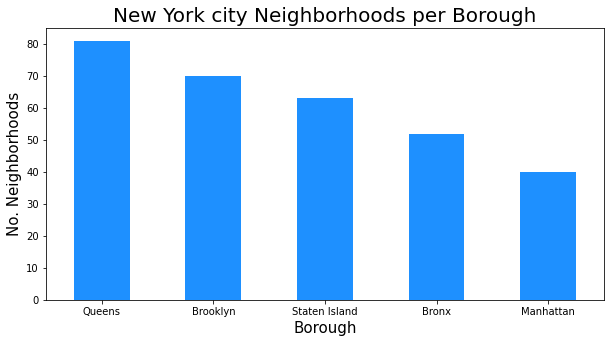

In [10]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().sort_values(ascending=False).plot.bar(figsize=(10,5), color=clr)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.title('New York city Neighborhoods per Borough', fontsize = 20)
plt.xticks(rotation = 'horizontal')
plt.show()

### FourSqaure API
**Lets continue to analyze further and see how many coffee shops there are in each neighborhood and borough using Foursquare API and graph the results.**

**We're interested in venues called coffe shopsso we will ignore 'Cafe' category for now because of the Foursquare API limit on premium calls.**

In [11]:
# use this if you want to include cafe
# coffee_shops = venues[(venues['Category']=='Coffee Shop') | (venues['Category'] == 'Café')]

**Let's fetch the venues using Foursquare API**

In [12]:
# prepare neighborhood list that contains 'coffee shop'
column_names=['Borough', 'Neighborhood', 'ID','Name']
ny_coffee_shops=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    
    coffee_shops = venues[venues['Category']=='Coffee Shop']

#     print('(',count,'/',len(ny_data),')','Coffee Shop in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
#     print(row)

    for cafe_shops_detail in coffee_shops.values.tolist():
        id, name , category=cafe_shops_detail
        ny_coffee_shops = ny_coffee_shops.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

**How many coffee shops are  there in New York City?**

In [13]:
display(ny_coffee_shops.shape)
ny_coffee_shops.tail()

(316, 4)

,Borough,Neighborhood,ID,Name
311,Brooklyn,Dumbo,5995fc8cbcbf7a4289076636,Starbucks
312,Bronx,Kingsbridge Heights,4b71c776f964a520fb5b2de3,Perista
313,Bronx,Kingsbridge Heights,4c483d70c047be9a430c3379,Starbucks
314,Manhattan,Hudson Yards,5c683caaf96b2c00397a8609,Oslo Coffee Roasters
315,Manhattan,Hudson Yards,526d9114498ec8efda93fcce,Romeo and Juliet Coffee


**Accoding to Foursquare API, there are are about 318 coffee shops in New York City**

**Save the Foursquare information to a .csv file**

In [14]:
#save to .csv
# ny_coffee_shops.to_csv('ny_coffee_shops_to_csv.csv',index=False) 

### Load csv file

In [15]:
#load csv
ny_coffee_shops = pd.read_csv('ny_coffee_shops_to_csv.csv',index_col=False)

#check dataset
ny_coffee_shops.tail()

,Borough,Neighborhood,ID,Name
313,Bronx,Kingsbridge Heights,4b71c776f964a520fb5b2de3,Perista
314,Bronx,Kingsbridge Heights,4c483d70c047be9a430c3379,Starbucks
315,Bronx,Kingsbridge Heights,5156f35be4b0dc046e1af723,Perista Coffee Shop
316,Manhattan,Hudson Yards,5c683caaf96b2c00397a8609,Oslo Coffee Roasters
317,Manhattan,Hudson Yards,526d9114498ec8efda93fcce,Romeo and Juliet Coffee


**Total number of coffee shops per borough**

In [16]:
ny_coffee_shops.groupby('Borough')['Name'].count().sort_values(ascending=False)

Borough
Manhattan        150
Brooklyn          96
Queens            38
Staten Island     17
Bronx             17
Name: Name, dtype: int64

**Even though Manhattan has the fewest neighborhoods, half of the coffee shops are located in Manhattan. State Island and Bronx have the least number of coffee shops.**

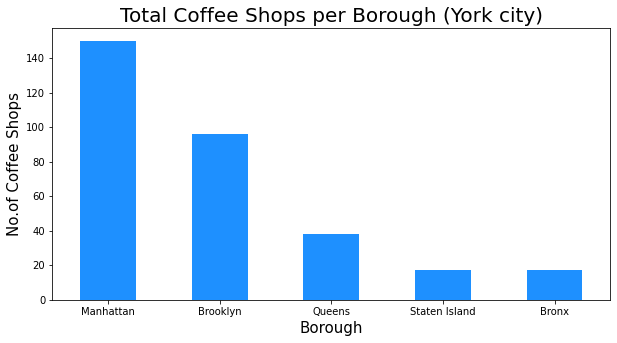

In [17]:
ny_coffee_shops.groupby('Borough')['ID'].count().sort_values(ascending=False).plot.bar(figsize=(10,5), color = clr)
plt.title('Total Coffee Shops per Borough (York city)', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Coffee Shops', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

**Count the total number of coffee shops for each Neighborhood.**

In [18]:
ny_coffee_shops.groupby('Neighborhood')['Name'].count().sort_values(ascending=False).to_frame().head()

,Name
Neighborhood,
Financial District,12
North Side,11
Murray Hill,8
Long Island City,8
Carnegie Hill,8


**The neighborhood of Financial District which is located in Manhattan borough does have the highest number of coffee shops out of all the neighborhoods. Let's see the top 15 neighborhoods that have the highest number of coffee shops.**

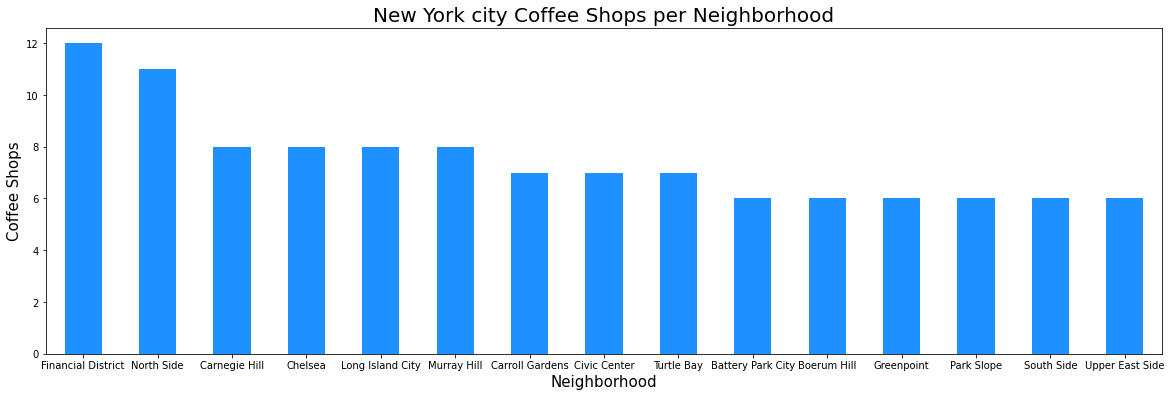

In [19]:
Num_of_neigh = 15 # top number for graphing all the same past 15
ny_coffee_shops.groupby('Neighborhood')['Name'].count().nlargest(Num_of_neigh).plot.bar(figsize=(20,6), color=clr)
plt.title('New York city Coffee Shops per Neighborhood', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Coffee Shops', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [20]:
ny_neighborhood_coffee_fd = ny_coffee_shops[(ny_coffee_shops['Neighborhood']=='Financial District')]
ny_neighborhood_coffee_fd

,Borough,Neighborhood,ID,Name
196,Manhattan,Financial District,574456e5498e39c73d234da1,Black Fox Coffee Co.
197,Manhattan,Financial District,5ef8e6aef272db0008a81a76,Blue Bottle
198,Manhattan,Financial District,561a8cd8498ed81f4384d0aa,La Colombe Torrefaction
199,Manhattan,Financial District,5cf965947564f7002c79aa21,For Five Coffee Roasters
200,Manhattan,Financial District,500d3cede4b0f6804faa90a8,Blue Spoon Coffee Co.
201,Manhattan,Financial District,566de7e3498e30e4798117ae,Voyager Espresso
202,Manhattan,Financial District,4a9ff5d9f964a520ba3d20e3,Starbucks
203,Manhattan,Financial District,5985db5e4420d80bedd5e6ef,Boundless Plains Espresso
204,Manhattan,Financial District,5f11ef5e938b7c3b5ead3c4f,Suited
205,Manhattan,Financial District,5dfa92d864192300086a1931,787 Coffee


**Since there are more coffee shops in Financial District, let's visualize Financial District neighborhood**

In [21]:
#coffee shops in Financial District
ny_coffee_shops[ny_coffee_shops['Neighborhood']=='Financial District']

,Borough,Neighborhood,ID,Name
196,Manhattan,Financial District,574456e5498e39c73d234da1,Black Fox Coffee Co.
197,Manhattan,Financial District,5ef8e6aef272db0008a81a76,Blue Bottle
198,Manhattan,Financial District,561a8cd8498ed81f4384d0aa,La Colombe Torrefaction
199,Manhattan,Financial District,5cf965947564f7002c79aa21,For Five Coffee Roasters
200,Manhattan,Financial District,500d3cede4b0f6804faa90a8,Blue Spoon Coffee Co.
201,Manhattan,Financial District,566de7e3498e30e4798117ae,Voyager Espresso
202,Manhattan,Financial District,4a9ff5d9f964a520ba3d20e3,Starbucks
203,Manhattan,Financial District,5985db5e4420d80bedd5e6ef,Boundless Plains Espresso
204,Manhattan,Financial District,5f11ef5e938b7c3b5ead3c4f,Suited
205,Manhattan,Financial District,5dfa92d864192300086a1931,787 Coffee


**Let's fetch the Likes , Rating , Tips using Foursquare API**

**Let's fetch the Likes , Rating and Tips using Foursquare API**

In [22]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']

ny_coffee_shops_stats=pd.DataFrame(columns=column_names)
count=1
for row in ny_coffee_shops.values.tolist():
    Borough,Neighborhood,ID,Name=row
    
    #get venue details as dataframe using 'ID'
    try:
        venue_details=get_venue_details(ID)
#         print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(ny_coffee_shops),')','processed')
    ny_coffee_shop_venue = ny_coffee_shops_stats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
ny_coffee_shop_venue.tail()

In [23]:
# display(ny_coffee_shop_venue.shape)
# ny_coffee_shop_venue.tail()

**save as csv**

In [24]:
#save data to a .csv 
# ny_coffee_shop_venue.to_csv('ny_coffee_shop_venue_to_csv.csv',index=False)

**read csv**

In [25]:
#read csv
ny_coffee_shop_venue = pd.read_csv('ny_coffee_shop_venue_to_csv.csv', index_col=False)
ny_coffee_shop_venue.head()

,Unnamed: 0,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,0,Bronx,Kingsbridge,5660c06b498e4003dba169a5,Mon Amour Coffee & Wine,22,8.4,7
1,1,Manhattan,Marble Hill,55f81cd2498ee903149fcc64,Starbucks,24,8.0,2
2,2,Manhattan,Marble Hill,57655be738faa66160da7527,Starbucks,7,7.2,0
3,3,Bronx,Norwood,4c6d5ce5e6b7b1f7af76a98e,Nicky's Coffee Shop,12,8.0,10
4,4,Bronx,Pelham Parkway,4bb62b326edc76b05d80301c,Liberty Donut & Coffee Shop,14,7.0,8


In [26]:
ny_coffee_shop_venue.shape

(100, 8)

## Data Processing and Cleaing

In [27]:
ny_coffee_shop_venue = ny_coffee_shop_venue.drop('Unnamed: 0', 1)
ny_coffee_shop_venue.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Kingsbridge,5660c06b498e4003dba169a5,Mon Amour Coffee & Wine,22,8.4,7
1,Manhattan,Marble Hill,55f81cd2498ee903149fcc64,Starbucks,24,8.0,2
2,Manhattan,Marble Hill,57655be738faa66160da7527,Starbucks,7,7.2,0
3,Bronx,Norwood,4c6d5ce5e6b7b1f7af76a98e,Nicky's Coffee Shop,12,8.0,10
4,Bronx,Pelham Parkway,4bb62b326edc76b05d80301c,Liberty Donut & Coffee Shop,14,7.0,8


**Remove duplicates from Pandas DataFrame**

In [28]:
ny_coffee_shop_venue_filt=pd.DataFrame.drop_duplicates(ny_coffee_shop_venue, subset = 'ID',keep ='first')
ny_coffee_shop_venue_filt.describe()

,Likes,Rating,Tips
count,62.000000,62.000000,62.000000
mean,62.290323,7.659677,18.806452
std,87.344126,1.269369,26.822329
min,0.000000,0.000000,0.000000
25%,13.000000,7.100000,4.000000
50%,24.000000,7.800000,8.500000
75%,84.500000,8.400000,24.000000
max,465.000000,9.100000,151.000000


In [29]:
display(ny_coffee_shop_venue_filt.shape)
ny_coffee_shop_venue_filt.sort_values(by = 'ID',ascending = True).tail()

(62, 7)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
30,Brooklyn,Prospect Heights,5d5021c8dbdd3d0008a39281,Coffee Spot,6,7.6,2
75,Brooklyn,Sunset Park,5d51c1639ce0d00008045cd4,Yafa,2,8.2,4
49,Brooklyn,Carroll Gardens,5d7ce692b4fc9c0008394021,Hungry Ghost,20,8.9,0
31,Brooklyn,Williamsburg,5d8663bddfbfcc0007278c66,Konditori,0,7.7,0
99,Brooklyn,Prospect Heights,5d920abe452d400008d5dc69,"Ciao, Gloria",40,8.9,9


**Lets remove coffee shops where ID = 0**

In [30]:
ny_coffee_shop_venue_filt
ny_coffee_shop_venue_filt = ny_coffee_shop_venue_filt[ny_coffee_shop_venue_filt["ID"] !='0']
ny_coffee_shop_venue_filt.sort_values(by ='Rating', ascending = False, inplace = True)
ny_coffee_shop_venue_filt.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
48,Brooklyn,Carroll Gardens,58d933702f91cb026f478e38,East One Coffee Roasters,244,9.1,36
76,Brooklyn,Greenpoint,54d43863498e653d2ab8343f,Early,129,9.0,30
18,Brooklyn,Greenpoint,576eb1f5cd10a371033f7ad6,Maman,179,8.9,36
15,Brooklyn,Greenpoint,518cf9ec498e8c38bda0268d,Homecoming,217,8.9,45
49,Brooklyn,Carroll Gardens,5d7ce692b4fc9c0008394021,Hungry Ghost,20,8.9,0


In [31]:
ny_coffee_shop_venue_filt.groupby('Borough')['Name'].count()

Borough
Bronx        13
Brooklyn     46
Manhattan     2
Name: Name, dtype: int64

### Descriptive Analytics
Average rating of the neighborhood coffee shops is 7.75

In [32]:
ny_coffee_shop_venue.describe()

,Likes,Rating,Tips
count,100.000000,100.000000,100.000000
mean,54.840000,6.846000,16.250000
std,82.122933,2.646569,25.179507
min,0.000000,0.000000,0.000000
25%,7.000000,6.900000,2.000000
50%,21.000000,7.750000,7.000000
75%,68.000000,8.400000,20.250000
max,465.000000,9.100000,151.000000


**Neighborhood total number of coffee shops**

In [33]:
ny_coffee_shop_venue_filt.groupby('Neighborhood')['Name'].count().sort_values(ascending = False).head().to_frame()

,Name
Neighborhood,
Greenpoint,8
Bushwick,5
Prospect Heights,5
Cobble Hill,4
Bedford Stuyvesant,3


**let's visualize the total number of coffee shops per neighborhood**

[Text(0.5, 0, 'Coffee Shops'), Text(0, 0.5, 'Neighborhood')]

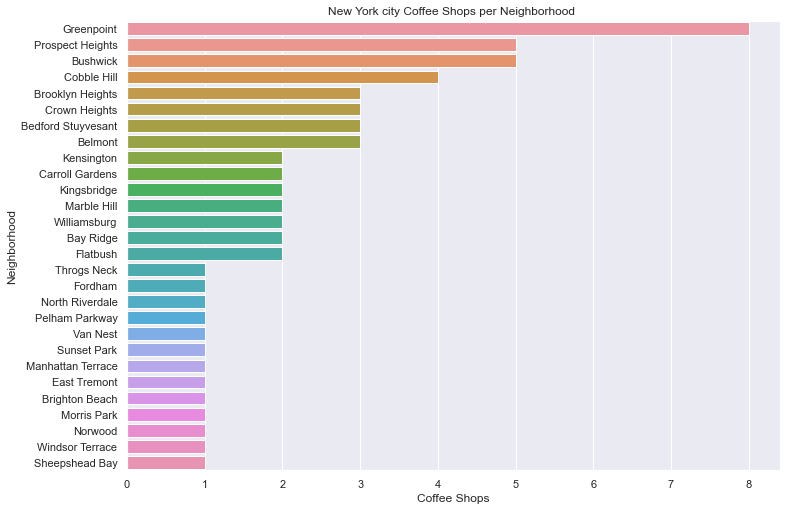

In [34]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.countplot(data = ny_coffee_shop_venue_filt, y='Neighborhood', order = ny_coffee_shop_venue_filt['Neighborhood'].value_counts().index)
g.set(title='New York city Coffee Shops per Neighborhood ')
g.set(xlabel="Coffee Shops", ylabel = "Neighborhood")

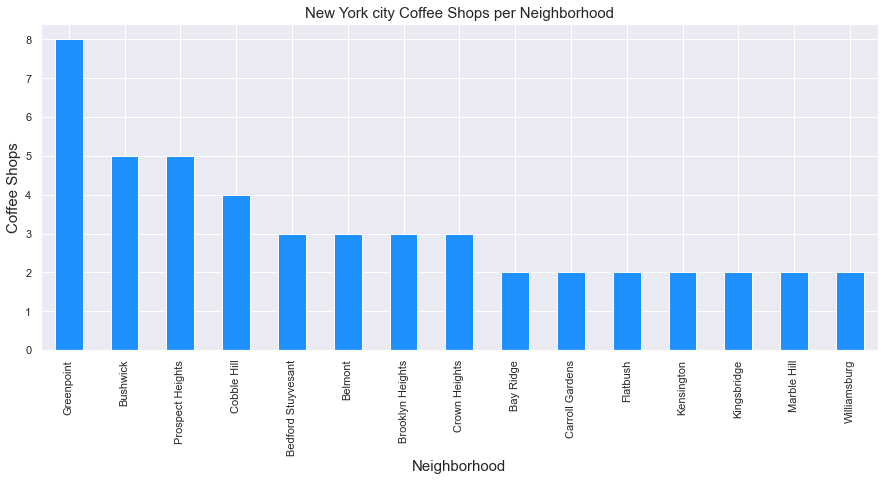

In [35]:
Num_of_neigh = 15 # top number for graphing all the same past 15
ny_coffee_shop_venue_filt.groupby('Neighborhood')['Name'].count().nlargest(Num_of_neigh).plot.bar(figsize=(15,6), color=clr)
plt.title('New York city Coffee Shops per Neighborhood', fontsize = 15)
plt.xlabel('Neighborhood',fontsize = 15)
plt.ylabel('Coffee Shops',fontsize = 15)
# plt.xticks(rotation = 'horizontal')
plt.show()

In [36]:
ny_coffee_shop_venue_filt['Likes']=ny_coffee_shop_venue_filt['Likes'].astype('float64')
ny_coffee_shop_venue_filt['Tips']=ny_coffee_shop_venue_filt['Tips'].astype('float64')
ny_coffee_shop_venue_filt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 48 to 85
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       61 non-null     object 
 1   Neighborhood  61 non-null     object 
 2   ID            61 non-null     object 
 3   Name          61 non-null     object 
 4   Likes         61 non-null     float64
 5   Rating        61 non-null     float64
 6   Tips          61 non-null     float64
dtypes: float64(3), object(4)
memory usage: 6.3+ KB


In [37]:
ny_coffee_shop_venue_filt.describe()

,Likes,Rating,Tips
count,61.000000,61.000000,61.000000
mean,63.311475,7.785246,19.114754
std,87.695029,0.802670,26.933930
min,0.000000,6.000000,0.000000
25%,13.000000,7.100000,4.000000
50%,24.000000,7.800000,9.000000
75%,85.000000,8.400000,24.000000
max,465.000000,9.100000,151.000000


**Where is the best coffee shop located at?**

In [38]:
## Coffee shop with maximum Ratings
ny_coffee_shop_venue_filt.sort_values(by='Rating',ascending = False).head(10)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
48,Brooklyn,Carroll Gardens,58d933702f91cb026f478e38,East One Coffee Roasters,244.0,9.1,36.0
76,Brooklyn,Greenpoint,54d43863498e653d2ab8343f,Early,129.0,9.0,30.0
18,Brooklyn,Greenpoint,576eb1f5cd10a371033f7ad6,Maman,179.0,8.9,36.0
15,Brooklyn,Greenpoint,518cf9ec498e8c38bda0268d,Homecoming,217.0,8.9,45.0
49,Brooklyn,Carroll Gardens,5d7ce692b4fc9c0008394021,Hungry Ghost,20.0,8.9,0.0
99,Brooklyn,Prospect Heights,5d920abe452d400008d5dc69,"Ciao, Gloria",40.0,8.9,9.0
41,Brooklyn,Brooklyn Heights,59d7872e5a2c911745c2e8ca,Joe Coffee,95.0,8.8,13.0
29,Brooklyn,Prospect Heights,5a6cc216f5e9d763b7a37c8f,Gran Caffe De Martini,27.0,8.7,7.0
28,Brooklyn,Prospect Heights,4a2407e6f964a520ef7d1fe3,Sit & Wonder,305.0,8.7,117.0
7,Bronx,Van Nest,4c1c5630e9c4ef3b4ccd45aa,Conti's Pastry Shoppe,47.0,8.7,15.0


**East One Coffee Roasters in Carroll Garden has the highest customer rating.**\
**Plot neighborhood against the rating**

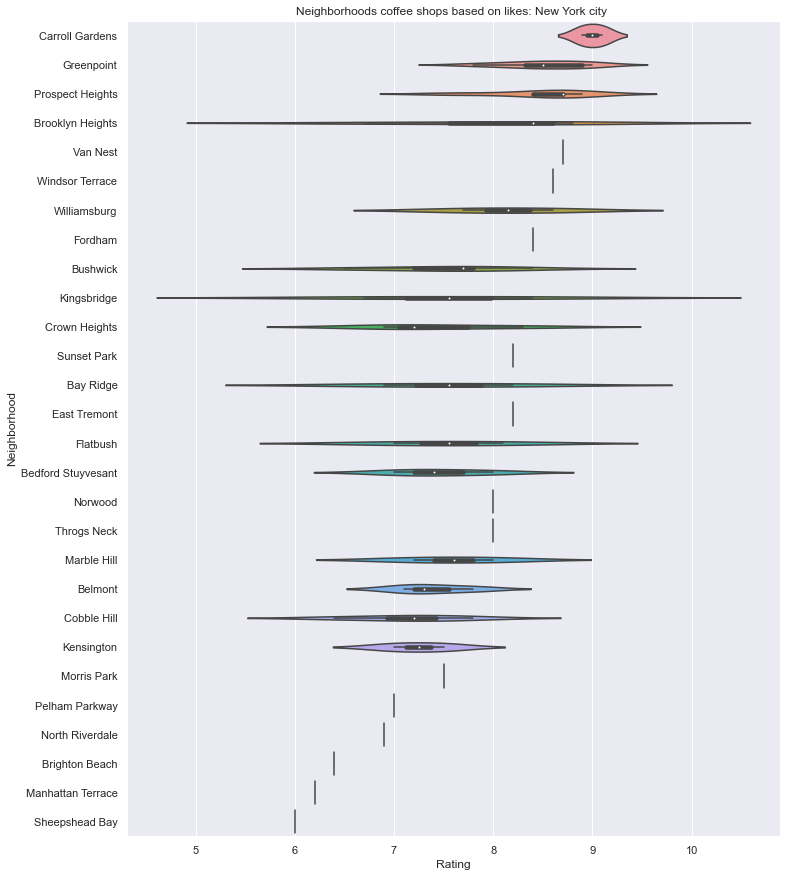

In [39]:
sns.set(rc={'figure.figsize':(11.7,15)})
g = sns.violinplot(data = ny_coffee_shop_venue_filt, y='Neighborhood', x='Rating')
g.set(title='Neighborhoods coffee shops based on likes: New York city ')
sns.set(font_scale = 1)

**Vineapple Cafe coffee shops has the maximum Likes**

In [40]:
# Coffee shop with maximum Likes
ny_coffee_shop_venue_filt.sort_values(by='Likes',ascending = False).head(10)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
42,Brooklyn,Brooklyn Heights,4de26e06814df7ebdc14af8b,Vineapple Cafe,465.0,8.4,151.0
28,Brooklyn,Prospect Heights,4a2407e6f964a520ef7d1fe3,Sit & Wonder,305.0,8.7,117.0
45,Brooklyn,Cobble Hill,55423f82498e5156ac21cfb6,Swallow Cafe,253.0,7.8,47.0
48,Brooklyn,Carroll Gardens,58d933702f91cb026f478e38,East One Coffee Roasters,244.0,9.1,36.0
15,Brooklyn,Greenpoint,518cf9ec498e8c38bda0268d,Homecoming,217.0,8.9,45.0
18,Brooklyn,Greenpoint,576eb1f5cd10a371033f7ad6,Maman,179.0,8.9,36.0
43,Brooklyn,Brooklyn Heights,4acf7fb1f964a5201dd420e3,Starbucks,170.0,6.7,49.0
20,Brooklyn,Greenpoint,55cf6244498e24c4ebe3ae0b,Sweetleaf,170.0,8.5,24.0
19,Brooklyn,Greenpoint,4d8f7d48d265236a02c72117,Upright Coffee,159.0,7.8,49.0
21,Brooklyn,Brighton Beach,4b59aedcf964a520999228e3,Starbucks,129.0,6.4,37.0


**Coffee shop with maximum Tips**

In [41]:
#Coffee shop with maximum Tips
ny_coffee_shop_venue_filt.sort_values(by='Tips',ascending = False).head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
42,Brooklyn,Brooklyn Heights,4de26e06814df7ebdc14af8b,Vineapple Cafe,465.0,8.4,151.0
28,Brooklyn,Prospect Heights,4a2407e6f964a520ef7d1fe3,Sit & Wonder,305.0,8.7,117.0
57,Bronx,Fordham,51bb492d498e4a3ea2ebf17d,Primavera Cafe,26.0,8.4,79.0
19,Brooklyn,Greenpoint,4d8f7d48d265236a02c72117,Upright Coffee,159.0,7.8,49.0
43,Brooklyn,Brooklyn Heights,4acf7fb1f964a5201dd420e3,Starbucks,170.0,6.7,49.0


**Neighborhood average ratings**

In [42]:
ny_neighborhood_coffee_shops=ny_coffee_shop_venue_filt.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_coffee_shops.columns=['Neighborhood','Average_Rating']
ny_neighborhood_coffee_shops.sort_values(['Average_Rating'],ascending=False).head()

,Neighborhood,Average_Rating
6,Carroll Gardens,9.0000
25,Van Nest,8.7000
27,Windsor Terrace,8.6000
12,Greenpoint,8.5125
21,Prospect Heights,8.4600


**Where is the best neighborhood to open coffee business?**

**Show boroughs based on the highest average rating**

In [43]:
ny_borough_coffee_shops=ny_coffee_shop_venue_filt.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_coffee_shops.columns=['Borough','Average_Rating']
ny_borough_coffee_shops.sort_values(['Average_Rating'],ascending=False).head()

,Borough,Average_Rating
1,Brooklyn,7.819565
0,Bronx,7.692308
2,Manhattan,7.600000


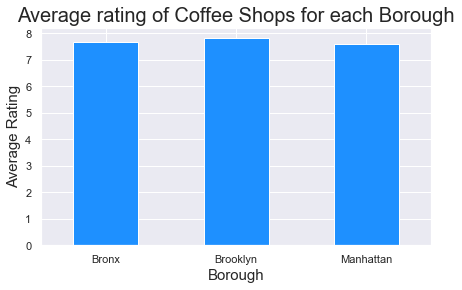

In [44]:
ny_coffee_shop_venue_filt.groupby('Borough').mean()['Rating'].plot.bar(figsize=(7,4), color=clr)
plt.title('Average rating of Coffee Shops for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

**Filter neighborhoods with an average rating greater than or equal to 8**

In [45]:
# ny_neighborhood_coffee_shops_stats=ny_neighborhood_coffee_shops_stats[ny_neighborhood_coffee_shops_stats['Average_Rating']>=8.0]
ny_neighborhood_coffee_shops[ny_neighborhood_coffee_shops['Average_Rating']>=8.0]
ny_neighborhood_coffee_shops.sort_values(['Average_Rating'],ascending=False, inplace = True)
ny_neighborhood_coffee_shops.head()

,Neighborhood,Average_Rating
6,Carroll Gardens,9.0000
25,Van Nest,8.7000
27,Windsor Terrace,8.6000
12,Greenpoint,8.5125
21,Prospect Heights,8.4600


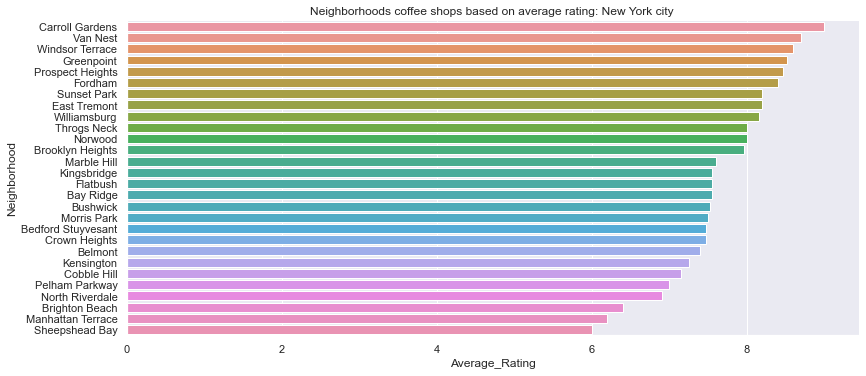

In [46]:
g = sns.catplot(data = ny_neighborhood_coffee_shops, y='Neighborhood', x='Average_Rating', kind='bar',aspect=2.4)
g.set(title='Neighborhoods coffee shops based on average rating: New York city ')

**Let's add Borough,Latitude, Longitude to the above data frame.**

In [47]:
ny_neighborhood_coffee_shops=pd.merge(ny_neighborhood_coffee_shops,ny_data, on='Neighborhood')
ny_neighborhood_coffee_shops=ny_neighborhood_coffee_shops[['Borough','Neighborhood','Latitude','Longitude','Average_Rating']]
ny_neighborhood_coffee_shops.sort_values(by ='Average_Rating', ascending=False).head(5)

,Borough,Neighborhood,Latitude,Longitude,Average_Rating
0,Brooklyn,Carroll Gardens,40.680540,-73.994654,9.0000
1,Bronx,Van Nest,40.843608,-73.866299,8.7000
2,Brooklyn,Windsor Terrace,40.656946,-73.980073,8.6000
3,Brooklyn,Greenpoint,40.730201,-73.954241,8.5125
4,Brooklyn,Prospect Heights,40.676822,-73.964859,8.4600


**Map of NYC neighborhoods**

In [48]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_coffee_shops[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [49]:
ny_neighborhood_coffee_shops['Label']=ny_neighborhood_coffee_shops['Borough']+', '+ny_neighborhood_coffee_shops['Neighborhood']+'('+ny_neighborhood_coffee_shops['Average_Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_coffee_shops[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

**Finally, lets visualize all NYC boroughs based on average Rating.**

In [50]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_coffee_shops,
    columns=['Borough', 'Average_Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
# Save the map to a file since it is huge data
ny_map.save('borough_rating.html')

### Analyzing Clusters

In [51]:
# one hot encoding and adjust the name prefix
col = ['Borough','Neighborhood']

# onehot encoding
cafe_onehot = pd.get_dummies(ny_coffee_shop_venue_filt[['Name']], prefix="", prefix_sep="")

# add neighborhood and Borough columns back to the dataframe
cafe_onehot[col] = ny_neighborhood_coffee_shops[col]
cafe_onehot

,Angelica's Coffee Shop,Bakerie,Brooklyn Kava,Brooklyn Kettle,Bushwick Public House,Cafe Aziza 7,Cafe Riviera,Caffe Cafe,Central Cafe,Chock Full O' Nuts,Chocolatte Espresso Bar,"Ciao, Gloria",Coffee Mob,Coffee Rx,Coffee Spot,Coffee Z,Conti's Pastry Shoppe,Crocus Coffee,Daytime,Dweebs,Early,East One Coffee Roasters,Espresso Me,Fare & Folk,Gold Mine Cafe,Gran Caffe De Martini,Homecoming,Hungry Ghost,Jenny Coffe Shop #2,Joe Coffee,Konditori,La Casa Del Caffe,Lazy Suzy Cafe & Shop,Liberty Donut & Coffee Shop,Maman,Mon Amour Coffee & Wine,Nicky's Coffee Shop,Noni's Coffee Shop,North Star Cafe,Primavera Cafe,Prince Coffee House,Pueblo Querido Coffee Roasters,"S,T Coffee",Salter House,Sit & Wonder,Soho Cafe & Grill,Starbucks,Swallow Cafe,Sweetleaf,The Flat's BK Speed Coffee,The Miles Coffee Bar,Upright Coffee,Vineapple Cafe,Yafa,odd fox,Borough,Neighborhood
48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Brooklyn,Bedford Stuyvesant
15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Brooklyn,Bay Ridge
49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
99,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Bronx,East Tremont
28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN
29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN


In [52]:
cafe_onehot.shape

(61, 57)

In [53]:
len(cafe_onehot.Neighborhood.unique())

24

In [54]:
# Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
ny_neighborhood_grouped = cafe_onehot.groupby(by='Neighborhood').mean().reset_index()
ny_neighborhood_grouped.head()

,Neighborhood,Angelica's Coffee Shop,Bakerie,Brooklyn Kava,Brooklyn Kettle,Bushwick Public House,Cafe Aziza 7,Cafe Riviera,Caffe Cafe,Central Cafe,Chock Full O' Nuts,Chocolatte Espresso Bar,"Ciao, Gloria",Coffee Mob,Coffee Rx,Coffee Spot,Coffee Z,Conti's Pastry Shoppe,Crocus Coffee,Daytime,Dweebs,Early,East One Coffee Roasters,Espresso Me,Fare & Folk,Gold Mine Cafe,Gran Caffe De Martini,Homecoming,Hungry Ghost,Jenny Coffe Shop #2,Joe Coffee,Konditori,La Casa Del Caffe,Lazy Suzy Cafe & Shop,Liberty Donut & Coffee Shop,Maman,Mon Amour Coffee & Wine,Nicky's Coffee Shop,Noni's Coffee Shop,North Star Cafe,Primavera Cafe,Prince Coffee House,Pueblo Querido Coffee Roasters,"S,T Coffee",Salter House,Sit & Wonder,Soho Cafe & Grill,Starbucks,Swallow Cafe,Sweetleaf,The Flat's BK Speed Coffee,The Miles Coffee Bar,Upright Coffee,Vineapple Cafe,Yafa,odd fox
0,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bedford Stuyvesant,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Belmont,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,Brighton Beach,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Brooklyn Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [55]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [56]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        # Add column names: 1st, 2nd, 3rd Most Common Venue
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        # Add column names such as 4th, 5th, .. ,10th Most Common Venue
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# In the end, we have:
# columns == ['Neighborhood', '1st Most Common Venue', .. , '10th Most Common Venue']        

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_neighborhood_grouped['Neighborhood']

for ind in np.arange(ny_neighborhood_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_neighborhood_grouped.iloc[ind, :], num_top_venues)

In [57]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bay Ridge,Homecoming,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
1,Bedford Stuyvesant,Maman,odd fox,Homecoming,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
2,Belmont,Sweetleaf,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
3,Brighton Beach,Jenny Coffe Shop #2,odd fox,Homecoming,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
4,Brooklyn Heights,Noni's Coffee Shop,odd fox,Homecoming,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime


In [58]:
from sklearn.cluster import KMeans

# run k-means clustering
kclusters = 3

ny_neigh_grouped_cluster = ny_neighborhood_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_neigh_grouped_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1])

In [59]:
# add clustering labels
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted['Cluster Labels'] = pd.Series(kmeans.labels_)
neighborhoods_venues_sorted

# merge neighborhoods_venues_sorted with ny_neighborhood_coffee_shops_stats to add latitude/longitude for each neighborhood
ny_neighborhood_merged = neighborhoods_venues_sorted.join(ny_neighborhood_coffee_shops.set_index('Neighborhood'), on='Neighborhood')

ny_neighborhood_merged.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Borough,Latitude,Longitude,Average_Rating,Label
0,Bay Ridge,Homecoming,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime,0,Brooklyn,40.625801,-74.030621,7.550000,"Brooklyn, Bay Ridge(7.55)"
1,Bedford Stuyvesant,Maman,odd fox,Homecoming,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime,2,Brooklyn,40.687232,-73.941785,7.466667,"Brooklyn, Bedford Stuyvesant(7.466666666666666)"
2,Belmont,Sweetleaf,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime,0,Bronx,40.857277,-73.888452,7.400000,"Bronx, Belmont(7.3999999999999995)"
3,Brighton Beach,Jenny Coffe Shop #2,odd fox,Homecoming,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime,0,Brooklyn,40.576825,-73.965094,6.400000,"Brooklyn, Brighton Beach(6.4)"
4,Brooklyn Heights,Noni's Coffee Shop,odd fox,Homecoming,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime,0,Brooklyn,40.695864,-73.993782,7.966667,"Brooklyn, Brooklyn Heights(7.966666666666668)"


**Let's rearrange the columns**

In [60]:
columns = [column for column in ny_neighborhood_merged.columns if column.endswith('Venue')]

#columns order
columns = ['Borough', 'Neighborhood', 'Cluster Labels','Average_Rating','Latitude','Longitude'] + columns
ny_neighborhood_merged= ny_neighborhood_merged[columns]
ny_neighborhood_merged.head()

,Borough,Neighborhood,Cluster Labels,Average_Rating,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,0,7.550000,40.625801,-74.030621,Homecoming,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
1,Brooklyn,Bedford Stuyvesant,2,7.466667,40.687232,-73.941785,Maman,odd fox,Homecoming,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
2,Bronx,Belmont,0,7.400000,40.857277,-73.888452,Sweetleaf,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
3,Brooklyn,Brighton Beach,0,6.400000,40.576825,-73.965094,Jenny Coffe Shop #2,odd fox,Homecoming,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
4,Brooklyn,Brooklyn Heights,0,7.966667,40.695864,-73.993782,Noni's Coffee Shop,odd fox,Homecoming,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime


In [61]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library

# create map
map_clusters = folium.Map(location=geo_location('New York'), zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, poi, cluster in zip(ny_neighborhood_merged['Latitude'], ny_neighborhood_merged['Longitude'], ny_neighborhood_merged['Neighborhood'], ny_neighborhood_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
        
map_clusters

# Save the map to a file
map_clusters.save('Coffeeshops_clustering.html')
map_clusters

#### How many Neighborhoods per Cluster?

In [62]:
# How many neighborhoods in each cluster
ny_neighborhood_merged['Cluster Labels'].value_counts()

0    17
1     5
2     1
Name: Cluster Labels, dtype: int64

**Cluster 1**

In [63]:
cluster_1 = ny_neighborhood_merged.loc[ny_neighborhood_merged['Cluster Labels'] == 0, ny_neighborhood_merged.columns[[1] + list(range(6, ny_neighborhood_merged.shape[1]))]]
cluster_1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bay Ridge,Homecoming,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
2,Belmont,Sweetleaf,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
3,Brighton Beach,Jenny Coffe Shop #2,odd fox,Homecoming,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
4,Brooklyn Heights,Noni's Coffee Shop,odd fox,Homecoming,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
5,Bushwick,Pueblo Querido Coffee Roasters,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
6,Carroll Gardens,Mon Amour Coffee & Wine,odd fox,Homecoming,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
7,Cobble Hill,Chock Full O' Nuts,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
8,Crown Heights,Upright Coffee,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
9,East Tremont,Conti's Pastry Shoppe,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
10,Greenpoint,Nicky's Coffee Shop,odd fox,Homecoming,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime


**Cluster 2**

In [64]:
cluster_2 = ny_neighborhood_merged.loc[ny_neighborhood_merged['Cluster Labels'] == 1, ny_neighborhood_merged.columns[[1] + list(range(6, ny_neighborhood_merged.shape[1]))]]
cluster_2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Kensington,Starbucks,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
14,Norwood,Starbucks,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
19,Throgs Neck,Starbucks,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
20,Van Nest,Starbucks,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime
22,Windsor Terrace,Starbucks,odd fox,Coffee Rx,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime


**Cluster 3**

In [65]:
cluster_3 = ny_neighborhood_merged.loc[ny_neighborhood_merged['Cluster Labels'] == 2, ny_neighborhood_merged.columns[[1] + list(range(6, ny_neighborhood_merged.shape[1]))]]
cluster_3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bedford Stuyvesant,Maman,odd fox,Homecoming,Gold Mine Cafe,Fare & Folk,Espresso Me,East One Coffee Roasters,Early,Dweebs,Daytime


**The most common coffee shops in cluster 1**

In [66]:
first = cluster_1.iloc[:,0:2].groupby('1st Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
first.rename(columns={'1st Most Common Venue':'Coffee shop name'}, inplace=True)
first

,Coffee shop name,Neighborhood
0,Angelica's Coffee Shop,1
1,Mon Amour Coffee & Wine,1
2,Upright Coffee,1
3,The Miles Coffee Bar,1
4,Sweetleaf,1
5,Pueblo Querido Coffee Roasters,1
6,Noni's Coffee Shop,1
7,Nicky's Coffee Shop,1
8,Liberty Donut & Coffee Shop,1
9,Chock Full O' Nuts,1


In [67]:
second = cluster_1[['Neighborhood','2nd Most Common Venue']].groupby('2nd Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
second.rename(columns={'2nd Most Common Venue':'Coffee shop name'}, inplace=True)
second

,Coffee shop name,Neighborhood
0,odd fox,14
1,Coffee Rx,3


In [68]:
third = cluster_1[['Neighborhood','3rd Most Common Venue']].groupby('3rd Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
third.rename(columns={'3rd Most Common Venue':'Coffee shop name'}, inplace=True)
third

,Coffee shop name,Neighborhood
0,Coffee Rx,8
1,Homecoming,6
2,Gold Mine Cafe,3


In [69]:
ny_top_cafes = pd.concat([first, second, third])
ny_top_cafes = ny_top_cafes.groupby(by='Coffee shop name').sum().sort_values(by='Neighborhood', ascending=False)
ny_top_cafes.head()

,Neighborhood
Coffee shop name,
odd fox,15
Coffee Rx,11
Homecoming,7
Gold Mine Cafe,3
Mon Amour Coffee & Wine,1


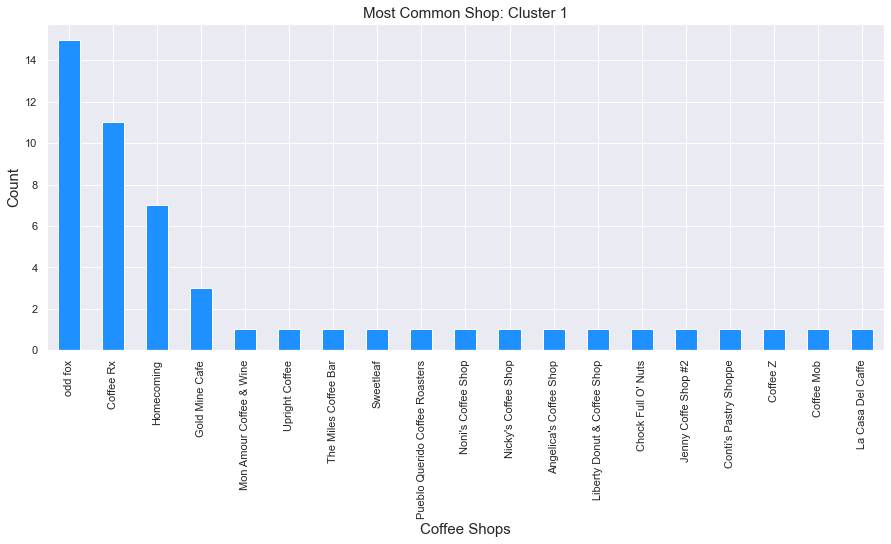

In [70]:
Num_of_neigh = 10 # top number for graphing all the same past 15
ny_top_cafes.groupby('Coffee shop name')['Neighborhood'].nlargest(Num_of_neigh).plot.bar(figsize=(15,6), color=clr)
plt.title('Most Common Shop: Cluster 1', fontsize = 15)
plt.ylabel('Count',fontsize = 15)
plt.xlabel('Coffee Shops',fontsize = 15)
plt.show()

**The most common coffee shops in cluster 2**

In [71]:
first_2 = cluster_2.iloc[:,0:2].groupby('1st Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
first_2.rename(columns={'1st Most Common Venue':'Coffee shop name'}, inplace=True)
first_2

,Coffee shop name,Neighborhood
0,Starbucks,5


In [72]:
second_2 = cluster_2[['Neighborhood','2nd Most Common Venue']].groupby('2nd Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
second_2.rename(columns={'2nd Most Common Venue':'Coffee shop name'}, inplace=True)
second_2

,Coffee shop name,Neighborhood
0,odd fox,5


In [73]:
third_2 = cluster_2[['Neighborhood','3rd Most Common Venue']].groupby('3rd Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
third_2.rename(columns={'3rd Most Common Venue':'Coffee shop name'}, inplace=True)
third_2

,Coffee shop name,Neighborhood
0,Coffee Rx,5


**The most common coffee shops in cluster 3**

In [74]:
first_3 = cluster_3.iloc[:,0:2].groupby('1st Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
first_3.rename(columns={'1st Most Common Venue':'Coffee shop name'}, inplace=True)
first_3

,Coffee shop name,Neighborhood
0,Maman,1
